## call "~/.local/bin/poetry" if poetry keyword not working on mac

In [1]:
import datetime
import geopandas
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
# TODO try only with best performing numeric columns for input into model first
# TODO select features for deep learning model after ranking features with random forest (feature importance)
# TODO lstm network
# DONE TODO SMOTE algorithm, for upsampling havested fields; we only have ~300 :(
    
    
# TODO convert sample_idx into cyclic numeric values using sin or cos.
    # https://datascience.stackexchange.com/questions/17759/encoding-features-like-month-and-hour-as-categorial-or-numeric
    


In [3]:
# 1- upsample with smote DONE
# 2- select best featues with random forests

In [4]:
#local scripts

from scripts import veg_indices, utilities, plots
#from scripts.utilities import *

In [5]:
# cpied from learning_about-data.ipynb
BANDS_DICT = {   'B2': 'Blue',
            'B3': 'Green',
            'B4': 'Red',
            'B5': 'Red_Edge_1',
            'B6': 'Red_Edge_2',
            'B7': 'Red_Edge_3',
            'B8': 'NIR',
            'B8A': 'Red_Edge_4',
            'B11': 'SWIR_1',
            'B12': 'SWIR_2'}

BANDS = list(BANDS_DICT.keys())

In [6]:
# cpied from learning_about-data.ipynb
DF = geopandas.read_file('../data/merged_images.geojson')
DF.rename(columns = {'is_within_period':'har_evnt'}, inplace = True)
NUM_SAMPLES = len(np.unique(DF.image_idx)) - 1

In [7]:
DF

,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,NDVI,finHarvDat,lat,lon,point_idx,start_date,end_date,har_evnt,image_idx,geometry
0,0.1000,0.1000,0.100,0.1000,0.1000,0.10000,0.10000,0.10000,0.1000,0.1000,0.000000,2022-08-11,50.655048,25.458684,p0,2022-01-08,2022-01-28,False,i0,POINT (25.45868 50.65505)
1,0.1000,0.1000,0.100,0.1000,0.1000,0.10000,0.10000,0.10000,0.1000,0.1000,0.000000,NaT,50.294633,36.289471,p1,2022-01-08,2022-01-28,False,i0,POINT (36.28947 50.29463)
2,0.1000,0.1000,0.100,0.1000,0.1000,0.10000,0.10000,0.10000,0.1000,0.1000,0.000000,NaT,50.860849,32.548484,p2,2022-01-08,2022-01-28,False,i0,POINT (32.54848 50.86085)
3,0.1000,0.1000,0.100,0.1000,0.1000,0.10000,0.10000,0.10000,0.1000,0.1000,0.000000,NaT,50.928689,31.637558,p3,2022-01-08,2022-01-28,False,i0,POINT (31.63756 50.92869)
4,0.1424,0.1083,0.030,0.0432,0.0631,0.07150,0.07760,0.08510,0.1066,0.1043,0.256335,2022-07-23,48.307964,37.348245,p4,2022-01-08,2022-01-28,False,i0,POINT (37.34824 48.30796)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9481,0.2557,0.1875,0.065,0.0740,0.0973,0.11695,0.14255,0.15525,0.1920,0.1847,0.327342,NaT,49.723156,36.817274,p553,2022-12-10,2022-12-30,False,i16,POINT (36.81727 49.72316)
9482,0.1616,0.1235,0.028,0.0442,0.0525,0.06390,0.08950,0.09310,0.1152,0.1073,0.373882,NaT,45.578351,28.700480,p554,2022-12-10,2022-12-30,False,i16,POINT (28.70048 45.57835)
9483,0.1675,0.1030,0.043,0.0678,0.0460,0.10960,0.23980,0.26430,0.2832,0.2783,0.720535,NaT,46.693510,35.051003,p555,2022-12-10,2022-12-30,False,i16,POINT (35.05100 46.69351)
9484,0.1000,0.1000,0.100,0.1000,0.1000,0.10000,0.10000,0.10000,0.1000,0.1000,0.000000,2022-07-30,50.451929,33.668204,p556,2022-12-10,2022-12-30,False,i16,POINT (33.66820 50.45193)


In [8]:
# cpied from learning_about-data.ipynb
df = DF.copy()
df = df[(df.NDVI) != 0] # drop invalid points
VEG_INDICES_NAMES = veg_indices.add_veg_indices(df) + ['NDVI'] 
VEG_DIFF_NAMES = veg_indices.add_veg_diff(df, VEG_INDICES_NAMES)
NUMERIC_COLS = BANDS + VEG_INDICES_NAMES + VEG_DIFF_NAMES
df = df.dropna(subset=['sample_idx']) # removes the first image, because sample_idx is NaN there


""" 
# only look at samples 6, 7, 8, 9
new_df = None
for i in range(6, 9 + 1):

    curr_df = df[df["sample_idx"] == f"s{i}"]
    if(type(new_df) == type(None)):
        new_df = curr_df
    else:
        new_df = pd.concat([new_df, curr_df])
df = new_df
"""

print(df.columns, df.shape)


# For each 3-week image, standarize each column
df = utilities.get_rm_outlier_standarize(df, NUMERIC_COLS, rm_outliers=False)

all_df_cols = list(df.columns)


Added:  ['RVI', 'ARVI', 'PSSRa', 'NDI45', 'GNDVI', 'MCARI', 'IRECI', 'CIr', 'MTCI', 'NDVIre', 'NIRv', 'EVI', 'NDTI', 'NDMI', 'MSI', 'GCI', 'NBRI', 'BSI', 'NDWI', 'NDSI']
Added:  ['sample_idx', 'RVI_diff', 'ARVI_diff', 'PSSRa_diff', 'NDI45_diff', 'GNDVI_diff', 'MCARI_diff', 'IRECI_diff', 'CIr_diff', 'MTCI_diff', 'NDVIre_diff', 'NIRv_diff', 'EVI_diff', 'NDTI_diff', 'NDMI_diff', 'MSI_diff', 'GCI_diff', 'NBRI_diff', 'BSI_diff', 'NDWI_diff', 'NDSI_diff', 'NDVI_diff']
Index(['B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'NDVI',
       'finHarvDat', 'lat', 'lon', 'point_idx', 'start_date', 'end_date',
       'har_evnt', 'image_idx', 'geometry', 'RVI', 'ARVI', 'PSSRa', 'NDI45',
       'GNDVI', 'MCARI', 'IRECI', 'CIr', 'MTCI', 'NDVIre', 'NIRv', 'EVI',
       'NDTI', 'NDMI', 'MSI', 'GCI', 'NBRI', 'BSI', 'NDWI', 'NDSI', 'pt_idx',
       'img_idx', 'RVI_diff', 'ARVI_diff', 'PSSRa_diff', 'NDI45_diff',
       'GNDVI_diff', 'MCARI_diff', 'IRECI_diff', 'CIr_diff', 'MTCI_diff',
       

#### metric0: Bhattacharyya Distance
- s6
    * RVI
    * NDVI
- s7
    * B12
    * B4
    * NDMI_diff
- s8
    * NDSI_diff
    * NDI45
- s9 
    * NDSI_diff
    * NBRI
    * BSI_diff
- ["RVI", "NDVI", "B12", "B4", "NDMI_diff", "NDSI_diff", "NDI45", "NDSI_diff", "NBRI", "BSI_diff"]



#### metric1: Hellinger Distance (same results as metric0!)
- s6
    * RVI
    * NDVI
- s7
    * B12
    * B4
    * NDMI_diff
- s8
    * NDSI_diff
    * NDI45
- s9 
    * NDSI_diff
    * NBRI
    * BSI_diff

    
#### metric2: Two-sample Kolmogorov Smirnov test P-Value
- s6
    * RVI
    * BSI_diff
- s7
    * NDVI
    * IRECI_diff
- s8
    * BSI_diff
    * NBRI
    * NBRI_diff
    * NDMI
    * ARVI
    * MSI_diff
- s9 
    * BSI_diff
    * IRECI_diff
- ["RVI", "BSI_diff", "NDVI", "IRECI_diff", "BSI_diff", "NBRI", "NBRI_diff", "NDMI", "ARVI", "MSI_diff"]


#### metric3: Jensen-Shannon Divergence (JSD) 
- s6
    * B6
    * NDVIre_diff
    * B2
- s7
    * ARVI_diff
    * B6
    * B7
    * B8A
- s8
    * B12
- s9 
    * MTCI
    * NDVIre_diff

- ["B6", "NDVIre_diff", "B2", "ARVI_diff", "B6", "B7", "B8A", "B12", "MTCI", "NDVIre_diff"]

In [9]:
def get_manually_selected():
    METRIC0 = ["RVI", "NDVI", "B12", "B4", "NDMI_diff", "NDSI_diff", "NDI45", "NDSI_diff", "NBRI", "BSI_diff"]
    METRIC1 = METRIC0
    METRIC2 = ["RVI", "BSI_diff", "NDVI", "IRECI_diff", "BSI_diff", "NBRI", "NBRI_diff", "NDMI", "ARVI", "MSI_diff"]
    METRIC3 = ["B6", "NDVIre_diff", "B2", "ARVI_diff", "B6", "B7", "B8A", "B12", "MTCI", "NDVIre_diff"]

    return np.unique(np.concatenate([METRIC0, METRIC1, METRIC2, METRIC3]))

def get_ordered_rdm_forests_features():
    # first one is the most important
    return ['MTCI', 'NDVIre_diff', 'NDVI_diff', 'MTCI_diff', 'PSSRa', 'NDI45_diff',
       'EVI_diff', 'RVI', 'ARVI_diff', 'CIr', 'CIr_diff', 'NDTI_diff', 'NDVI',
       'NDI45', 'B11', 'NIRv_diff', 'NBRI_diff', 'PSSRa_diff', 'B4', 'B12',
       'MCARI', 'B5', 'B6', 'EVI', 'GCI_diff', 'MCARI_diff', 'GNDVI_diff',
       'NIRv', 'B3', 'NDMI_diff', 'B8', 'B7', 'IRECI_diff', 'NDTI', 'B8A',
       'NBRI', 'B2', 'NDSI', 'ARVI', 'NDVIre', 'GNDVI', 'IRECI', 'BSI_diff',
       'NDWI_diff', 'NDSI_diff', 'MSI_diff', 'GCI', 'BSI', 'MSI', 'NDMI',
       'NDWI']
    

#SELECTED_FEATURES = get_manually_selected()

#SELECTED_FEATURES = NUMERIC_COLS
#SELECTED_FEATURES = df[SELECTED_FEATURES].dropna(axis=1).columns


SELECTED_FEATURES = get_ordered_rdm_forests_features()[:21 + 1] # get top 21 features


print(SELECTED_FEATURES)

def get_X_y(dataframe: pd.DataFrame):
    df_X = dataframe[SELECTED_FEATURES]
    df_X = df_X.dropna(axis=1)
    X = df_X.to_numpy().reshape((df_X.shape[0], df_X.shape[1], 1))
    y = dataframe["har_evnt"].to_numpy().astype(np.float32)
    return X, y

['MTCI', 'NDVIre_diff', 'NDVI_diff', 'MTCI_diff', 'PSSRa', 'NDI45_diff', 'EVI_diff', 'RVI', 'ARVI_diff', 'CIr', 'CIr_diff', 'NDTI_diff', 'NDVI', 'NDI45', 'B11', 'NIRv_diff', 'NBRI_diff', 'PSSRa_diff', 'B4', 'B12', 'MCARI', 'B5']


# Random Upsampling (not used)

In [10]:
%%script echo skipping

har_evnt_true_df = df[df["har_evnt"]]
har_evnt_false_df = df[df["har_evnt"] == False]
print(har_evnt_true_df.shape)
print(har_evnt_false_df.shape)

from sklearn.utils import resample

upsampled_har_evnt_true_df = resample(har_evnt_true_df, n_samples=har_evnt_false_df.shape[0],
                                                 replace=True, random_state=42)
print(upsampled_har_evnt_true_df.shape)

df = pd.concat([upsampled_har_evnt_true_df, har_evnt_false_df])
df.shape

skipping


# Separate Train, Val datasets

In [11]:
            
points_df_list = []
for p in  df['point_idx'].unique(): # ['p0','p1','p2','p3','p4', ...]
    curr_df = df[df["point_idx"] == p]
    points_df_list.append(curr_df)
len(points_df_list)

556

In [12]:
from sklearn.model_selection import train_test_split

training_df_list, validation_df_list = train_test_split(points_df_list, train_size=0.8, random_state=42)


In [13]:
print(len(training_df_list))
print(len(validation_df_list))



444
112


# combine into two dataframes


In [14]:
train_df = pd.concat(training_df_list)
validate_df = pd.concat(validation_df_list)
train_df.shape, validate_df.shape

((5345, 64), (1333, 64))

# Convert to Numpy & SMOTE Upsampling

In [15]:
X_train, y_train = get_X_y(train_df)
print(X_train.shape, y_train.shape)
X_validate, y_validate = get_X_y(validate_df)
print(X_validate.shape, y_validate.shape)


(5345, 22, 1) (5345,)
(1333, 22, 1) (1333,)


In [16]:
import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter

def upsample(X, y):
    print(X.shape)
    # oversampling the train dataset using SMOTE
    smt = SMOTE()
    counter = Counter(y)
    print('Before',counter)
    X = X.reshape(X.shape[0], X.shape[1]) # remove last dim in (6678, 21, 1)
    X, y = smt.fit_resample(X, y)
    X_sm, y_sm = smt.fit_resample(X, y)

    counter = Counter(y_sm)
    print('After',counter)

    X = X.reshape(X.shape[0], X.shape[1], 1)
    print("")
    return X, y

X_train, y_train = upsample(X_train, y_train)


(5345, 22, 1)
Before Counter({0.0: 5082, 1.0: 263})
After Counter({0.0: 5082, 1.0: 5082})



In [17]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
model = tf.keras.Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    BatchNormalization(),
    Dense(units=32, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=8, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

#model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 320)               0         
                                                                 
 batch_normalization (BatchN  (None, 320)              1280      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                10272     
                                                                 
 dense_1 (Dense)             (None, 64)                2

In [19]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])


In [20]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_validate, y_validate))


Epoch 1/100


2023-05-11 20:25:43.970876: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


318/318 [==============================] - 1s 1ms/step - loss: 0.4639 - binary_accuracy: 0.7774 - val_loss: 0.3784 - val_binary_accuracy: 0.8447
Epoch 2/100
318/318 [==============================] - 0s 1ms/step - loss: 0.3523 - binary_accuracy: 0.8494 - val_loss: 0.4184 - val_binary_accuracy: 0.7922
Epoch 3/100
318/318 [==============================] - 0s 1ms/step - loss: 0.3211 - binary_accuracy: 0.8660 - val_loss: 0.3330 - val_binary_accuracy: 0.8507
Epoch 4/100
318/318 [==============================] - 0s 1ms/step - loss: 0.2838 - binary_accuracy: 0.8827 - val_loss: 0.3687 - val_binary_accuracy: 0.8402
Epoch 5/100
318/318 [==============================] - 0s 1ms/step - loss: 0.2703 - binary_accuracy: 0.8903 - val_loss: 0.3745 - val_binary_accuracy: 0.8432
Epoch 6/100
318/318 [==============================] - 0s 1ms/step - loss: 0.2525 - binary_accuracy: 0.9024 - val_loss: 0.2886 - val_binary_accuracy: 0.8965
Epoch 7/100
318/318 [==============================] - 0s 1ms/step - l

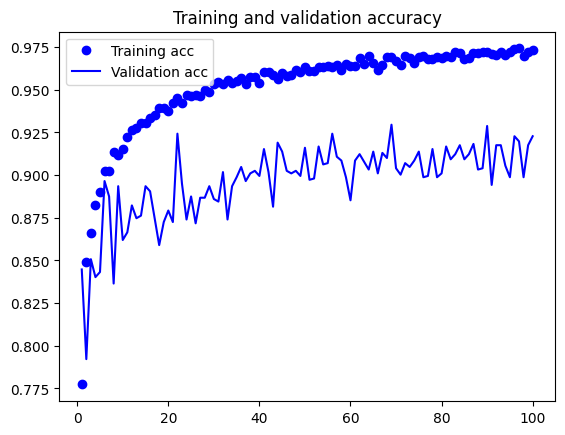

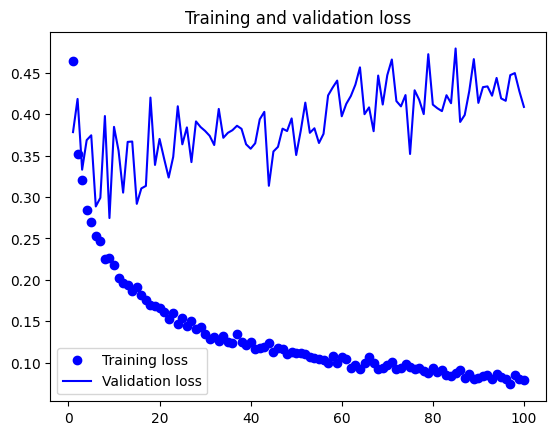

In [22]:
import matplotlib.pyplot as plt

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [66]:
def rm_extradim(X, y):
    X, y = X.reshape(X.shape[0], X.shape[1]), y.reshape(y.shape[0])
    return X, y

# Random Forests Feature Selection

In [67]:

X_train, y_train = rm_extradim(X_train, y_train)
X_validate, y_validate = rm_extradim(X_validate, y_validate)


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier()

rf.fit(X_train, y_train)
y_predict = rf.predict(X_validate)


accuracy_score(y_validate, y_predict)

0.9437359339834959

In [68]:
feature_importances_df = pd.DataFrame(rf.feature_importances_,
                    index=SELECTED_FEATURES, 
                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances_df

,importance
MTCI,0.061258
NDVIre_diff,0.054534
NDVI_diff,0.034346
MTCI_diff,0.033485
PSSRa,0.033333
NDI45_diff,0.032494
EVI_diff,0.029435
RVI,0.028255
ARVI_diff,0.027775
CIr,0.027578


In [74]:
feature_importances_df.T.columns

Index(['MTCI', 'NDVIre_diff', 'NDVI_diff', 'MTCI_diff', 'PSSRa', 'NDI45_diff',
       'EVI_diff', 'RVI', 'ARVI_diff', 'CIr', 'CIr_diff', 'NDTI_diff', 'NDVI',
       'NDI45', 'B11', 'NIRv_diff', 'NBRI_diff', 'PSSRa_diff', 'B4', 'B12',
       'MCARI', 'B5', 'B6', 'EVI', 'GCI_diff', 'MCARI_diff', 'GNDVI_diff',
       'NIRv', 'B3', 'NDMI_diff', 'B8', 'B7', 'IRECI_diff', 'NDTI', 'B8A',
       'NBRI', 'B2', 'NDSI', 'ARVI', 'NDVIre', 'GNDVI', 'IRECI', 'BSI_diff',
       'NDWI_diff', 'NDSI_diff', 'MSI_diff', 'GCI', 'BSI', 'MSI', 'NDMI',
       'NDWI'],
      dtype='object')

In [72]:
sorted(get_manually_selected())

['ARVI',
 'ARVI_diff',
 'B12',
 'B2',
 'B4',
 'B6',
 'B7',
 'B8A',
 'BSI_diff',
 'IRECI_diff',
 'MSI_diff',
 'MTCI',
 'NBRI',
 'NBRI_diff',
 'NDI45',
 'NDMI',
 'NDMI_diff',
 'NDSI_diff',
 'NDVI',
 'NDVIre_diff',
 'RVI']